### Shamelessly plagiarize code to understand how pytorchvideo works.
#### https://pytorchvideo.org/#quickstart

In [1]:
import torch
import pytorchvideo
import torchvision
from torchvision.transforms import Compose
from torchvision.transforms import Lambda
from torchvision.transforms import _functional_video as F

from pytorchvideo.data.encoded_video import EncodedVideo

from local_pytorch_video_transforms import NormalizeVideo
# For some reason, the following import does not work:
# from local_pytorch_video_transforms import CenterCropVideo
# So, I copy-pasted the code from local_pytorch_video_transforms.py into the IPython console.

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
)

import os

/home/devvrit/anaconda3/envs/mmvision/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(


In [2]:
import numbers

class CenterCropVideo(object):
    def __init__(self, crop_size):
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size

    def __call__(self, clip):
        """
        Args:
            clip (torch.tensor): Video clip to be cropped. Size is (C, T, H, W)
        Returns:
            torch.tensor: central cropping of video clip. Size is
            (C, T, crop_size, crop_size)
        """
        return F.center_crop(clip, self.crop_size)

    def __repr__(self):
        return self.__class__.__name__ + '(crop_size={0})'.format(self.crop_size)


In [3]:
DATA_PATH = "../../data/sample/"

VIDS = ["1001.mp4", "3050.mp4", "10000.mp4"]

num_frames = 16

# Borrowed from Kinetics
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

side_size = 256
crop_size = 224

In [4]:
model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)

# Load video
video = EncodedVideo.from_path(os.path.join(DATA_PATH, VIDS[0]))

# Compose video data transforms
transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size=(crop_size, crop_size))
        ]
    ),
)

Using cache found in /home/devvrit/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [5]:
# Get clip
clip_start_sec = 0.0 # secs
clip_duration = 2.0 # secs
video_data = video.get_clip(start_sec=clip_start_sec, end_sec=clip_start_sec + clip_duration)
video_data = transform(video_data)

vid = video_data["video"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 224, 224])


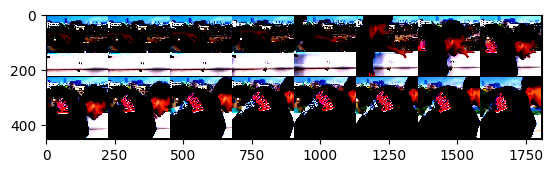

In [9]:
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

def show(img):
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

video = np.transpose(vid, (1, 0, 2, 3))

grid = vutils.make_grid(video)
show(grid) # here to use save_img func 

In [11]:
# video_data["video"] is a 4D tensor, but a 5D tensor is expected.
inputs = [i.to("cuda")[None, ...] for i in vid]

preds = model(inputs)

TypeError: conv3d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)


: 

In [ ]:
# Generate top 5 predictions
preds = torch.nn.functional.softmax(preds)
pred_class_ids = preds.topk(k=5).indices